# ETL reviews Yelp

### Optimización de los datasets originales

El archivo es muy grande para la tranformacion directa del mismo. Por ende lo dividimos en partes para que seas mas optimo y mas facil de trabajarlo. Lo particionamos sera de 300000 filas, que nos da como resultado 24 archivos.

In [1]:
# # Generamos partes de un tamaño de chunck 300000, genera 24 partes en json.
# def dividir_json_en_partes(archivo_entrada, tamaño_maximo, prefijo_salida):
#     with open(archivo_entrada, 'rb') as f_entrada:
#         # Inicializa la lista para almacenar cada parte del JSON
#         partes = []
#         numero_parte = 1

#         # Itera sobre cada línea del archivo JSON
#         for linea_binaria in f_entrada:
#             # Decodifica la línea binaria como UTF-8
#             linea = linea_binaria.decode('utf-8')

#             # Decodifica la línea como JSON
#             dato = json.loads(linea)

#             # Agrega el dato a la parte actual
#             partes.append(dato)

#             # Si la parte alcanza el tamaño máximo, guárdala y reinicia la lista
#             if len(partes) >= tamaño_maximo:
#                 guardar_parte(prefijo_salida, numero_parte, partes)
#                 numero_parte += 1
#                 partes = []

#         # Si hay datos restantes, guárdalos como la última parte
#         if partes:
#             guardar_parte(prefijo_salida, numero_parte, partes)

# def guardar_parte(prefijo_salida, numero_parte, datos):
#     nombre_salida = f"{prefijo_salida}_{numero_parte}.json"
#     with open(f'../extras/Datasets/Yelp/Pruebas/reviews_{nombre_salida}', 'w') as f_salida:
#         json.dump(datos, f_salida, indent=2)  # Puedes ajustar el nivel de indentación según tus preferencias

# # Especifica el archivo JSON de entrada, el tamaño máximo por parte y el prefijo para los archivos de salida

# # Llama a la función para dividir el JSON en partes
# dividir_json_en_partes('../extras/Datasets/Yelp/review.json', 300000, 'parte') 

Una vez dividido en partes lo guardamos en tipo parquet comprimido con gzip para que reduzca su tamaño.

In [2]:
# cantidad = list(range(1,25))

# def convertir_json_a_parquet(archivo_json, archivo_parquet):
#     # Lee el archivo JSON en un DataFrame de pandas
#     with open(archivo_json, 'r') as f:
#         datos_json = json.load(f)

#     # Convierte el JSON a un DataFrame de pandas
#     dataframe = pd.DataFrame(datos_json)

#     # Convierte el DataFrame de pandas a una tabla de PyArrow
#     tabla = pa.Table.from_pandas(dataframe)

#     # Escribe la tabla en un archivo Parquet
#     pq.write_table(tabla, archivo_parquet, compression='gzip')

# for i in cantidad:
#     # Especifica el archivo JSON de entrada y el archivo Parquet de salida
#     archivo_json = f'Datasets/Yelp/Pruebas/reviews_parte_{i}.json'
#     archivo_parquet = f'Datasets/Yelp/reviewsParquet/reviews_parte_{i}.gz.parquet'

#     # Llama a la función para convertir el JSON a Parquet
#     convertir_json_a_parquet(archivo_json, archivo_parquet)

### Tranformacion de los datos

#### Analisis de sentimiento

Importamos las librerias necesarias, y generamos el modelo de NLP para el analisis de sentimiento de la review.

In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download(['vader_lexicon', 'stopwords', 'names'])

sid = SentimentIntensityAnalyzer()

Para saber si un comentario es positivo, negativo o neutro, utilizamos polarity_scores que devuelve un diccionario de 4 claves, neg, neu, pos y compound. Las que nos interesa para clasificar la reseña es el compound, que es una puntuación compuesta de todo el texto. 

Para calificarlo además de usar esta función, utilizamos la clasificación que da el usuario mediante las estrellas. Por ende este valor lo dividimos por 5 asi nos quedan valores mas chicos y lo sumamos con el valor del compound previamente calculado.

Generamos esta función puntajeNLP para poder redondear este valor calculado por la suma antes mencionada, y ahi redondearlo a 2 (positivo), 0 (negativo), 1 (neutro).

In [4]:
def puntajeNLP(x):
    if x > 1.5:
        return 2 # Positivo
    elif x >= 1:
        return 1 # Neutro
    else: 
        return 0 # Negativo

In [ ]:
# Hacemos la tranformacion de todas las partes realizadas anteriormente.

for i in range(1,25):
    # Leemos el archivo
    df = pd.read_parquet(f'../extras/Datasets/Yelp/reviewsParquet/reviews_parte_{i}.gz.parquet')
    # Nos quedamos con las columnas que necesitamos
    df = df[['review_id', 'user_id', 'business_id','stars', 'text', 'date']]

    # Realizamos el analisis de sentimiento, la division de las estrellas y la suma de ambas para la clasificacion de la reseña.
    analisis = df['text'].apply(lambda x: sid.polarity_scores(x)["compound"])
    valorEstrellas = df['stars'] / 5 
    analisis += valorEstrellas
    analisis = analisis.apply(lambda x: puntajeNLP(x))

    # Reemplazamos la reseña por el analisis de sentimiento ya que son los datos necesarios y además para reducir el peso del archivo.
    df['text'] = analisis

    # Renombramos las columnas
    df.columns = ['review_id', 'user_id', 'business_id', 'stars' ,'sentiment', 'date']

    # Cambiamos tipo de dato.
    df['sentiment'] = df['sentiment'].astype('int8')

    # Exportamos el archivo para su proxima union.
    df.to_parquet(f'../extras/Datasets optimizados/Yelp/reviews_parte_{i}_gz.parquet', compression='gzip')

Unimos todos los datasets

In [7]:
df = pd.read_parquet('../extras/Datasets optimizados/Yelp/reviews procecados particionado/reviews_parte_1_gz.parquet')
for i in range(2,25):
    # Leemos el archivo
    aux = pd.read_parquet(f'../extras/Datasets optimizados/Yelp/reviews procecados particionado/reviews_parte_{i}_gz.parquet')
    df = pd.concat([df,aux], axis=0, ignore_index=True)

df.to_parquet('../extras/Datasets optimizados/yelp_total_reviews.gz.parquet', compression='gzip')

Hacemos el merge con los negocios que vamos a utilizar segun el criterio.

In [72]:
reviewsDf = pd.read_parquet('../extras/Datasets optimizados/Yelp/yelp_total_reviews.gz.parquet')

# Dataset de negocios ya filtrado por estado y tipo de negocio.
negociosDf = pd.read_parquet('../datasets/raw/bussiness_yelp_sin_criterio.parquet.gz')
# negociosDf = pd.read_parquet('../datasets/processed/yelp/bussiness_yelp.parquet.gz')

Generamos el dataset de las reviews que vamos a utilizar, y lo guardamos.

In [76]:
reviewsDf = reviewsDf.merge(negociosDf['business_id'], how='inner')
reviewsDf['date'] = pd.to_datetime(reviewsDf['date'])

reviewsDf.to_parquet('../datasets/raw/reviews_yelp_sin_criterio.parquet.gz', compression='gzip') 

# Analisis de reviews por año

In [50]:
reviewsDf = pd.read_parquet('../datasets/raw/reviews_yelp_sin_criterio.parquet.gz')

In [51]:
reviewsDf['date'].dt.year.value_counts()

date
2019    151257
2018    150872
2017    136635
2016    130546
2015    117914
2021    115990
2020    100691
2014     81330
2013     55464
2012     36948
2011     25469
2010     14733
2009      7842
2022      6083
2008      3941
2007      1853
2006       690
2005        77
Name: count, dtype: int64

C:\Users\Damian\AppData\Local\Temp\ipykernel_12968\1801872998.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(reviewsDf['date'].dt.year.value_counts(), palette='deep')


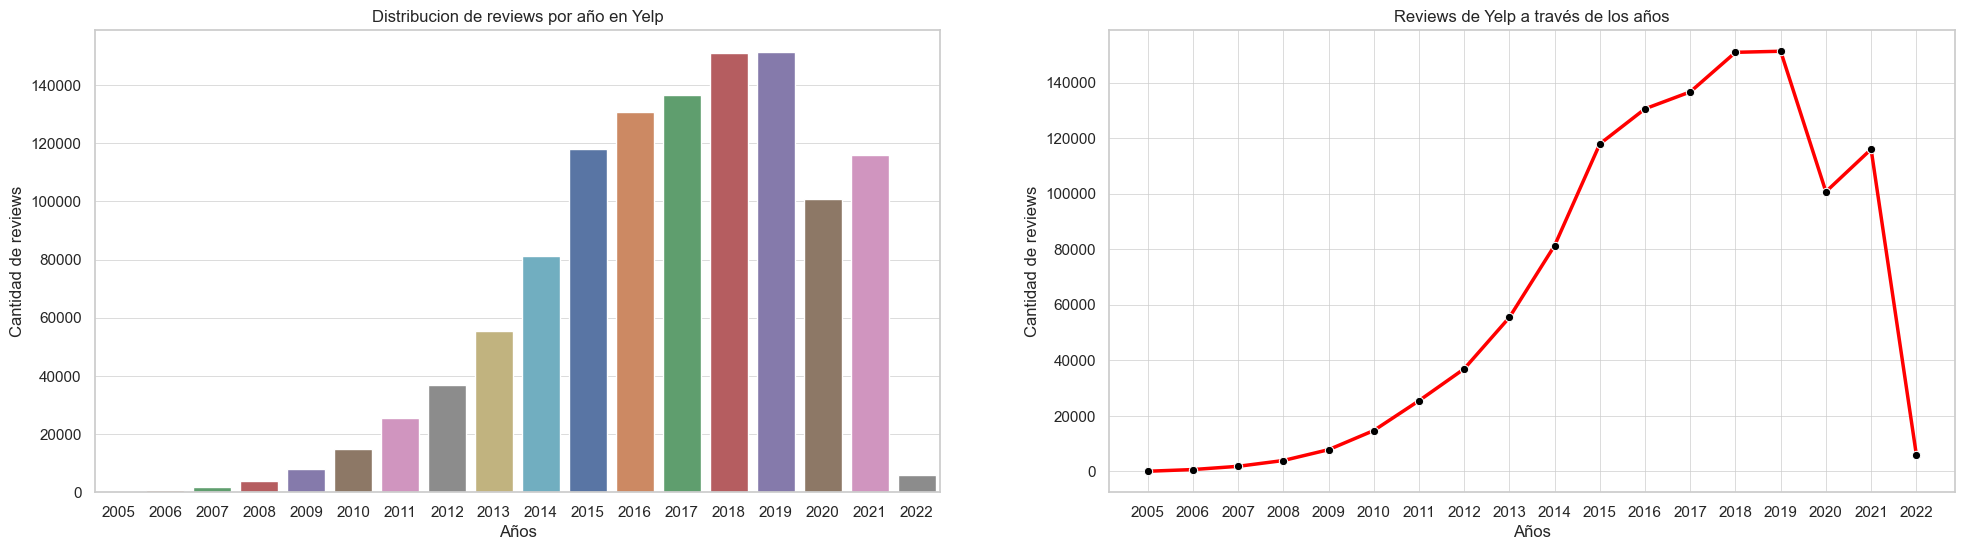

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.title('Distribucion de reviews por año en Yelp')
plt.ylabel('Cantidad de reviews')
plt.xlabel('Años')
sns.barplot(reviewsDf['date'].dt.year.value_counts(), palette='deep')

plt.subplot(1,2,2)
plt.title('Reviews de Yelp a través de los años')
plt.ylabel('Cantidad de reviews')
plt.xlabel('Años')
plt.xticks(list(range(2005,2023)))
sns.set(style="whitegrid",  rc={"grid.linewidth": 0.7, "grid.alpha": 0.7})
sns.lineplot(reviewsDf['date'].dt.year.value_counts(), marker='o', markerfacecolor='black', color='red', linestyle='solid', linewidth=2.5).set_axisbelow(True)


plt.show()

In [42]:
criterio = reviewsDf[reviewsDf['date'].dt.year >= 2015]['date'].dt.year.value_counts() 

<Axes: title={'center': 'Yelp'}, xlabel='date', ylabel='count'>

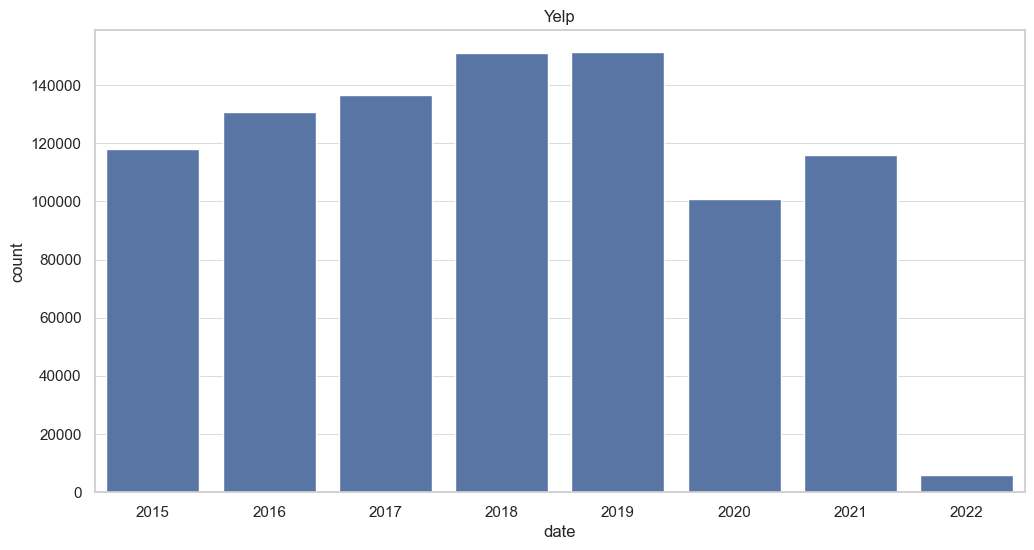

In [43]:
plt.figure(figsize=(12,6))
plt.title('Yelp')
sns.barplot(criterio)

### Aplicamos criterio de las reviews: 2015 en adelante

In [44]:
reviewsDf = reviewsDf[reviewsDf['date'].dt.year >= 2015]
reviewsDf.reset_index(drop=True, inplace=True)

Verificamos la informacion de usuarios que tenemos

In [45]:
user = pd.read_parquet(r'../extras/Datasets/Yelp/user.parquet')
user = user[['user_id']]

# Eliminamos duplicados
user.drop_duplicates(inplace=True)

In [46]:
reviewsDf

,review_id,user_id,business_id,stars,sentiment,date
0,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,2,2016-07-25 07:31:06
1,_Ub20uO1MKy4XOVPOdzpqw,lUYboGI6aFbZ0dX27pijpA,gebiRewfieSdtt17PTW6Zg,1.0,1,2017-06-28 01:04:59
2,-DjIfoNFAiT5J4kF9hXocQ,SrfDRvGKI8FQq9LCr0dQuQ,gebiRewfieSdtt17PTW6Zg,3.0,1,2017-01-14 23:31:35
3,URe-2Zlv7RoY4Ycr9JYVWw,SfMf7DEX7xT82OCcbZFsgQ,gebiRewfieSdtt17PTW6Zg,5.0,2,2016-07-14 23:09:38
4,qG1jG1r8TbCAercYDf_zmA,rrB_8jS1PAfx_kch6C2CBQ,gebiRewfieSdtt17PTW6Zg,1.0,1,2017-07-09 03:51:33
...,...,...,...,...,...,...
909983,HVYhSbKGyj2R39fTDY7sGg,7KBaoiKUhdTvOsRFOMGwZw,VnAJnVpXHOIBdg6qFJBc3g,1.0,1,2021-08-19 02:30:16
909984,CzJMAaOokvASWgVZg8B__w,L-h5y32VWEV60QXuDPW-hg,VnAJnVpXHOIBdg6qFJBc3g,1.0,1,2021-09-12 05:20:37
909985,9_ztYeoSwdz7S9TW8xkDQA,03q-tEfa2aJtKhf00ZZ-hg,VnAJnVpXHOIBdg6qFJBc3g,1.0,1,2021-04-25 13:44:37
909986,jDeNxby0ZI5UMsZzrywedA,NIlmQ38hxTR2w6lNSzJEuQ,VnAJnVpXHOIBdg6qFJBc3g,1.0,1,2021-10-06 01:52:41


In [47]:
pd.merge(reviewsDf, user[['user_id']], on='user_id')

,review_id,user_id,business_id,stars,sentiment,date
0,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,2,2016-07-25 07:31:06
1,qRhOkdYNO1URgn1WJfK1cg,59MxRhNVhU9MYndMkz0wtw,W7gSJz80DywKnPRIGjA2Bw,5.0,2,2016-07-25 07:20:23
2,ZZbpYMY4s8sVQGEU1jAuVA,59MxRhNVhU9MYndMkz0wtw,l_slvEnh4v3W8BXF1gYlcQ,5.0,2,2016-07-23 00:13:36
3,_Ub20uO1MKy4XOVPOdzpqw,lUYboGI6aFbZ0dX27pijpA,gebiRewfieSdtt17PTW6Zg,1.0,1,2017-06-28 01:04:59
4,-DjIfoNFAiT5J4kF9hXocQ,SrfDRvGKI8FQq9LCr0dQuQ,gebiRewfieSdtt17PTW6Zg,3.0,1,2017-01-14 23:31:35
...,...,...,...,...,...,...
909981,HVYhSbKGyj2R39fTDY7sGg,7KBaoiKUhdTvOsRFOMGwZw,VnAJnVpXHOIBdg6qFJBc3g,1.0,1,2021-08-19 02:30:16
909982,CzJMAaOokvASWgVZg8B__w,L-h5y32VWEV60QXuDPW-hg,VnAJnVpXHOIBdg6qFJBc3g,1.0,1,2021-09-12 05:20:37
909983,9_ztYeoSwdz7S9TW8xkDQA,03q-tEfa2aJtKhf00ZZ-hg,VnAJnVpXHOIBdg6qFJBc3g,1.0,1,2021-04-25 13:44:37
909984,jDeNxby0ZI5UMsZzrywedA,NIlmQ38hxTR2w6lNSzJEuQ,VnAJnVpXHOIBdg6qFJBc3g,1.0,1,2021-10-06 01:52:41


Como podemos ver tenemos 2 reviews que no tienen información de usuario, las cuales son eliminadas

In [48]:
reviewsDf = pd.merge(reviewsDf, user[['user_id']], on='user_id')

#### Exportamos

In [49]:
reviewsDf.to_parquet('../datasets/processed/yelp/reviews_yelp.parquet.gz')